# Word2Vec (Skipgram )


Importing Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.__version__

'3.7.2'

## 1. Load data

In [37]:
with open ("./data.txt", "r") as doc:
    corpus = doc.read()

In [38]:
corpus

'It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered as the rightful property of some one or other of their daughters.'

In [39]:
#1. tokenization
corpus = [corpus.split(" ") for sent in corpus]
corpus[0:5000]

[['It',
  'is',
  'a',
  'truth',
  'universally',
  'acknowledged,',
  'that',
  'a',
  'single',
  'man',
  'in',
  'possession',
  'of',
  'a',
  'good',
  'fortune,',
  'must',
  'be',
  'in',
  'want',
  'of',
  'a',
  'wife.',
  'However',
  'little',
  'known',
  'the',
  'feelings',
  'or',
  'views',
  'of',
  'such',
  'a',
  'man',
  'may',
  'be',
  'on',
  'his',
  'first',
  'entering',
  'a',
  'neighbourhood,',
  'this',
  'truth',
  'is',
  'so',
  'well',
  'fixed',
  'in',
  'the',
  'minds',
  'of',
  'the',
  'surrounding',
  'families,',
  'that',
  'he',
  'is',
  'considered',
  'as',
  'the',
  'rightful',
  'property',
  'of',
  'some',
  'one',
  'or',
  'other',
  'of',
  'their',
  'daughters.'],
 ['It',
  'is',
  'a',
  'truth',
  'universally',
  'acknowledged,',
  'that',
  'a',
  'single',
  'man',
  'in',
  'possession',
  'of',
  'a',
  'good',
  'fortune,',
  'must',
  'be',
  'in',
  'want',
  'of',
  'a',
  'wife.',
  'However',
  'little',
  'know

## Numeralization

In [6]:

#find unique words
flatten = lambda l: [item for sublist in l for item in sublist]
#assign unique integer
vocabs = list(set(flatten(corpus))) #all the words we have in the system - <UNK>

In [7]:
vocabs

['good',
 'be',
 'minds',
 'their',
 'that',
 'as',
 'considered',
 'want',
 'truth',
 'daughters.',
 'is',
 'views',
 'such',
 'first',
 'so',
 'However',
 'single',
 'feelings',
 'on',
 'acknowledged,',
 'well',
 'families,',
 'entering',
 'must',
 'It',
 'man',
 'he',
 'rightful',
 'neighbourhood,',
 'little',
 'or',
 'universally',
 'this',
 'surrounding',
 'in',
 'property',
 'wife.',
 'known',
 'some',
 'fixed',
 'one',
 'possession',
 'fortune,',
 'other',
 'a',
 'his',
 'the',
 'of',
 'may']

In [40]:
#create handy mapping between integer and word
word2index = {v:idx for idx, v in enumerate(vocabs)}
word2index

{'good': 0,
 'be': 1,
 'minds': 2,
 'their': 3,
 'that': 4,
 'as': 5,
 'considered': 6,
 'want': 7,
 'truth': 8,
 'daughters.': 9,
 'is': 10,
 'views': 11,
 'such': 12,
 'first': 13,
 'so': 14,
 'However': 15,
 'single': 16,
 'feelings': 17,
 'on': 18,
 'acknowledged,': 19,
 'well': 20,
 'families,': 21,
 'entering': 22,
 'must': 23,
 'It': 24,
 'man': 25,
 'he': 26,
 'rightful': 27,
 'neighbourhood,': 28,
 'little': 29,
 'or': 30,
 'universally': 31,
 'this': 32,
 'surrounding': 33,
 'in': 34,
 'property': 35,
 'wife.': 36,
 'known': 37,
 'some': 38,
 'fixed': 39,
 'one': 40,
 'possession': 41,
 'fortune,': 42,
 'other': 43,
 'a': 44,
 'his': 45,
 'the': 46,
 'of': 47,
 'may': 48,
 '<UNK>': 49}

In [42]:
#vocab size
voc_size = len(vocabs)
print(voc_size)

50


In [43]:
vocabs.append('<UNK>')
word2index['<UNK>'] = voc_size

In [45]:
index2word = {v:k for k, v in word2index.items()}

In [47]:
#vocab size
voc_size = len(vocabs)
print(voc_size)

51


## 2. Prepare train data

In [11]:
#create pairs of center word, and outside word

def random_batch(batch_size, corpus):

    skipgrams = []

    #loop each corpus
    for doc in corpus:
        #look from the 2nd word until second last word
        for i in range(1, len(doc)-1):
            #center word
            center = word2index[doc[i]]
            #outside words = 2 words
            outside = (word2index[doc[i-1]], word2index[doc[i+1]])
            #for each of these two outside words, we gonna append to a list
            for each_out in outside:
                skipgrams.append([center, each_out])
                #center, outside1;   center, outside2
                
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
x, y = random_batch(2, corpus)

In [12]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

Input:  [[31]
 [34]]
Target:  [[19]
 [25]]


## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [13]:
len(vocabs)

50

In [14]:
voc_size = len(vocabs)
voc_size

50

In [15]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center, outside, all_vocabs):
        center_embedding     = self.embedding_center(center)  #(batch_size, 1, emb_size)
        outside_embedding    = self.embedding_center(outside) #(batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs) #(batch_size, voc_size, emb_size)
        
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))
        #batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) = (batch_size, 1) 

        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        #batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size) 
        
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  #(batch_size, 1)
        
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  #scalar
        
        return loss
        

In [16]:
#prepare all vocabs

batch_size = 2
voc_size   = len(vocabs)

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  6],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,  6]])

In [17]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(50, 2)
  (embedding_outside): Embedding(50, 2)
)

In [18]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [19]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [20]:
loss

tensor(7.4771, grad_fn=<NegBackward0>)

## 4. Training

In [21]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [22]:
import time

num_epochs = 5000

start_time = time.time()

for epoch in range(num_epochs):
    
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    # backpropagate
    optimizer.zero_grad()
    loss.backward()
    
    # update alpha
    optimizer.step()
    
    # print the loss
    if (epoch + 1) % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f} | Elapsed Time: {elapsed_time:.2f} seconds")

end_time = time.time()

Epoch   1000 | Loss: 4.215305 | Elapsed Time: 27.97 seconds
Epoch   2000 | Loss: 4.343228 | Elapsed Time: 55.66 seconds
Epoch   3000 | Loss: 4.162175 | Elapsed Time: 83.28 seconds
Epoch   4000 | Loss: 4.345057 | Elapsed Time: 110.95 seconds
Epoch   5000 | Loss: 3.728881 | Elapsed Time: 140.34 seconds


In [23]:
# Calculate the total training time
total_time = end_time - start_time
print(f"Total Training Time: {total_time:.2f} seconds")

Total Training Time: 140.34 seconds


In [24]:
print(f'Training Loss: {loss}')

Training Loss: 3.728881359100342


In [25]:
# Saving the model for testing
torch.save(model.state_dict(), 'app/models/Word2VecSkipgram-v1.pt')

In [26]:
vocabs[:5]

['good', 'be', 'minds', 'their', 'that']

In [27]:
little = torch.LongTensor([word2index['little']])
little

tensor([29])

In [28]:
little_embed_c = model.embedding_center(little)
little_embed_o = model.embedding_outside(little)
little_embed   = (little_embed_c + little_embed_o) / 2
little_embed

tensor([[ 0.2354, -0.5760]], grad_fn=<DivBackward0>)

In [29]:
little_embed_o

tensor([[-0.6642, -0.5148]], grad_fn=<EmbeddingBackward0>)

In [30]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [31]:
get_embed('entering')

(-0.16406914591789246, 0.2071811854839325)

In [32]:
get_embed('daughters.')

(-0.8858453631401062, -0.2622235119342804)

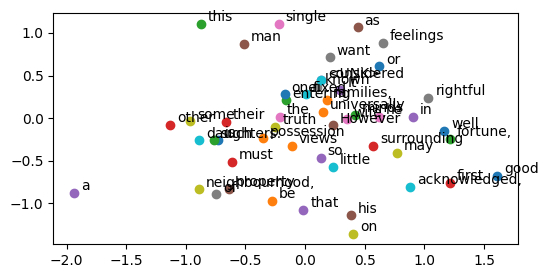

In [33]:
plt.figure(figsize=(6, 3))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [34]:
SkipgramData = {
    'corpus': corpus,
    'vocab': vocabs,
    'word2index': word2index,
    'voc_size': voc_size,
    'embedding_size': emb_size
}

In [35]:
import pickle
pickle.dump(SkipgramData,open('./app/models/SkipgramData.pkl', 'wb'))